## NLP. Medical Text Dataset -Cancer Doc Classification

    The dataset includes cancer documents to be classified into three categories: colon cancer = 2579, lung cancer = 2180, thyroid cancer = 2810, 

    I will use NLP to cluster this document. I first do data cleaning, then tokenization, then using stopword I remove frequent words and do lemmatization. 
    Then I train the data with: LogisticRegression, MultinomialNB, GaussianNB, BernoulliNB. 

### STEP 1: Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import re 
import string

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import yellowbrick
from yellowbrick.text import FreqDistVisualizer
import warnings
warnings.filterwarnings("ignore")
import nltk 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet
from wordcloud import WordCloud, STOPWORDS

import lime
from lime.lime_text import LimeTextExplainer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### STEP 2: Data analysis

In [2]:
nlp_data = pd.read_csv('../My_project/archive/alldata_1_for_kaggle.csv', encoding = "latin-1")
nlp_data

Unnamed: 0               0  \
0              0  Thyroid_Cancer   
1              1  Thyroid_Cancer   
2              2  Thyroid_Cancer   
3              3  Thyroid_Cancer   
4              4  Thyroid_Cancer   
...          ...             ...   
7565        7565    Colon_Cancer   
7566        7566    Colon_Cancer   
7567        7567    Colon_Cancer   
7568        7568    Colon_Cancer   
7569        7569    Colon_Cancer   

                                                      a  
0     Thyroid surgery in  children in a single insti...  
1     " The adopted strategy was the same as that us...  
2     coronary arterybypass grafting thrombosis ï¬b...  
3      Solitary plasmacytoma SP of the skull is an u...  
4      This study aimed to investigate serum matrix ...  
...                                                 ...  
7565  we report the case of a 24yearold man who pres...  
7566  among synchronous colorectal cancers scrcs rep...  
7567  the heterogeneity of cancer cells is generally...  
7568  "adipogenesis is the process through which mes...  
7569  the periparturient period is one of the most c...  

[7570 rows x 3 columns]

In [3]:
nlp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7570 entries, 0 to 7569
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7570 non-null   int64 
 1   0           7570 non-null   object
 2   a           7570 non-null   object
dtypes: int64(1), object(2)
memory usage: 177.5+ KB


In [4]:
nlp_data.describe()

Unnamed: 0
count  7570.000000
mean   3784.500000
std    2185.415102
min       0.000000
25%    1892.250000
50%    3784.500000
75%    5676.750000
max    7569.000000

In [5]:
nlp_data.drop("Unnamed: 0", axis = 1, inplace = True)

In [6]:
nlp_data.rename({"0":"cancer", "a":"text"}, axis = 1, inplace = True)

In [7]:
nlp_data

cancer                                               text
0     Thyroid_Cancer  Thyroid surgery in  children in a single insti...
1     Thyroid_Cancer  " The adopted strategy was the same as that us...
2     Thyroid_Cancer  coronary arterybypass grafting thrombosis ï¬b...
3     Thyroid_Cancer   Solitary plasmacytoma SP of the skull is an u...
4     Thyroid_Cancer   This study aimed to investigate serum matrix ...
...              ...                                                ...
7565    Colon_Cancer  we report the case of a 24yearold man who pres...
7566    Colon_Cancer  among synchronous colorectal cancers scrcs rep...
7567    Colon_Cancer  the heterogeneity of cancer cells is generally...
7568    Colon_Cancer  "adipogenesis is the process through which mes...
7569    Colon_Cancer  the periparturient period is one of the most c...

[7570 rows x 2 columns]

In [8]:
nlp_data['cancer'].unique()

array(['Thyroid_Cancer', 'Colon_Cancer', 'Lung_Cancer'], dtype=object)

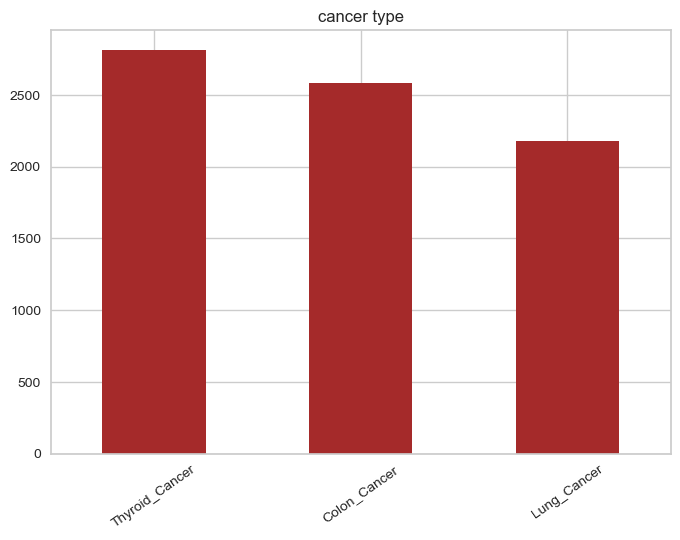

In [9]:
nlp_data['cancer'].value_counts().plot(kind = 'bar', color = 'brown')
plt.title('cancer type')
plt.xticks(rotation = 35)
plt.show()

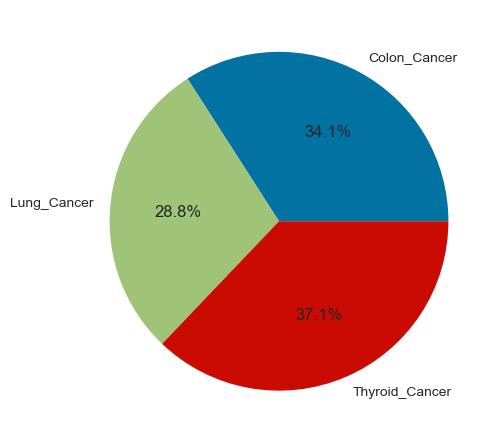

In [10]:
plt.pie(nlp_data.groupby('cancer')['cancer'].value_counts(),autopct="%.1f%%",labels=['Colon_Cancer','Lung_Cancer', 'Thyroid_Cancer'])
plt.show()

In [11]:
nlp_data['length_text'] = nlp_data['text'].apply(len)
nlp_data.head()

cancer                                               text  \
0  Thyroid_Cancer  Thyroid surgery in  children in a single insti...   
1  Thyroid_Cancer  " The adopted strategy was the same as that us...   
2  Thyroid_Cancer  coronary arterybypass grafting thrombosis ï¬b...   
3  Thyroid_Cancer   Solitary plasmacytoma SP of the skull is an u...   
4  Thyroid_Cancer   This study aimed to investigate serum matrix ...   

   length_text  
0        20707  
1        17018  
2        21622  
3        13860  
4        23696

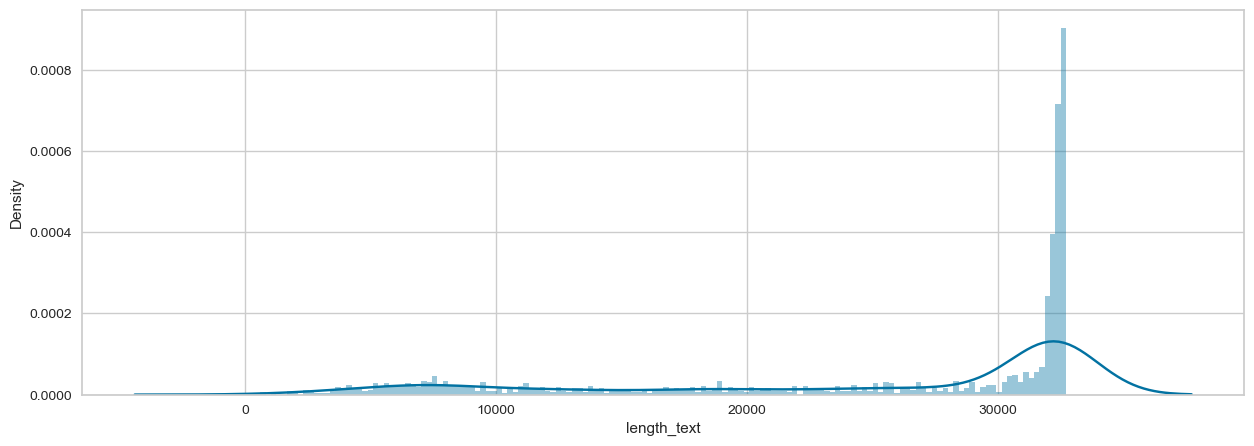

In [12]:
nlp_data['length_text'] = nlp_data['text'].str.len()
plt.figure(figsize=(15,5))
sns.distplot(nlp_data['length_text'],bins = 150)
xlabel= ('length_text') 
ylabel= ('Freq.')
plt.show()

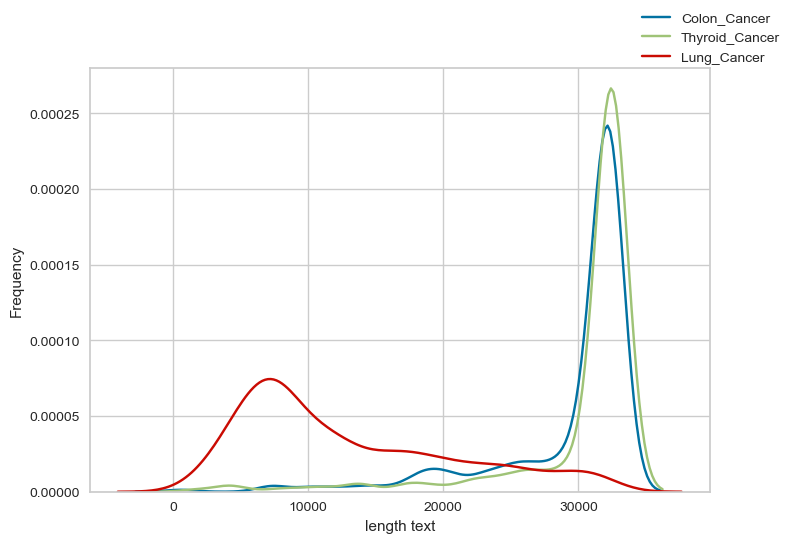

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

sns.kdeplot(nlp_data[nlp_data['cancer'] == 'Thyroid_Cancer']['length_text'])
sns.kdeplot(nlp_data[nlp_data['cancer'] == 'Colon_Cancer']['length_text'])
sns.kdeplot(nlp_data[nlp_data['cancer'] == 'Lung_Cancer']['length_text'])
ax.set(xlabel='length text', ylabel='Frequency')
fig.legend(labels=['Colon_Cancer','Thyroid_Cancer', 'Lung_Cancer'])
plt.show()

     Long sentences of more than 30,000 words are more often written about colon cancer, thyroid cancer.
     sentences of up to 10,000 words are more often written about lung cancer. 

<AxesSubplot:xlabel='cancer', ylabel='length_text'>

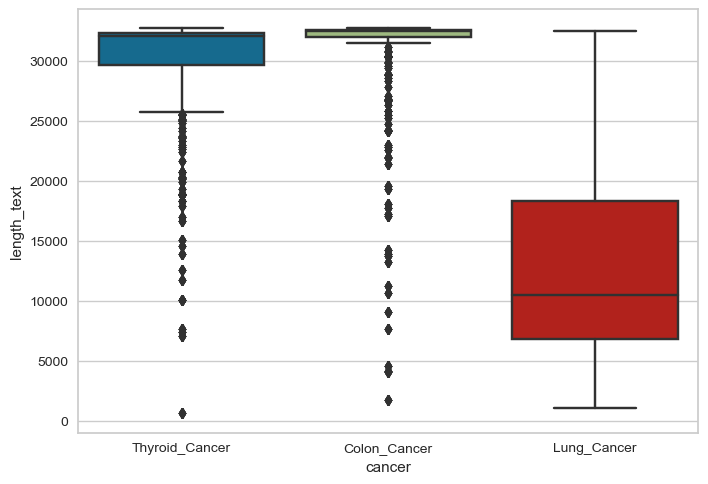

In [14]:
sns.boxplot(data = nlp_data, x = 'cancer', y = 'length_text')

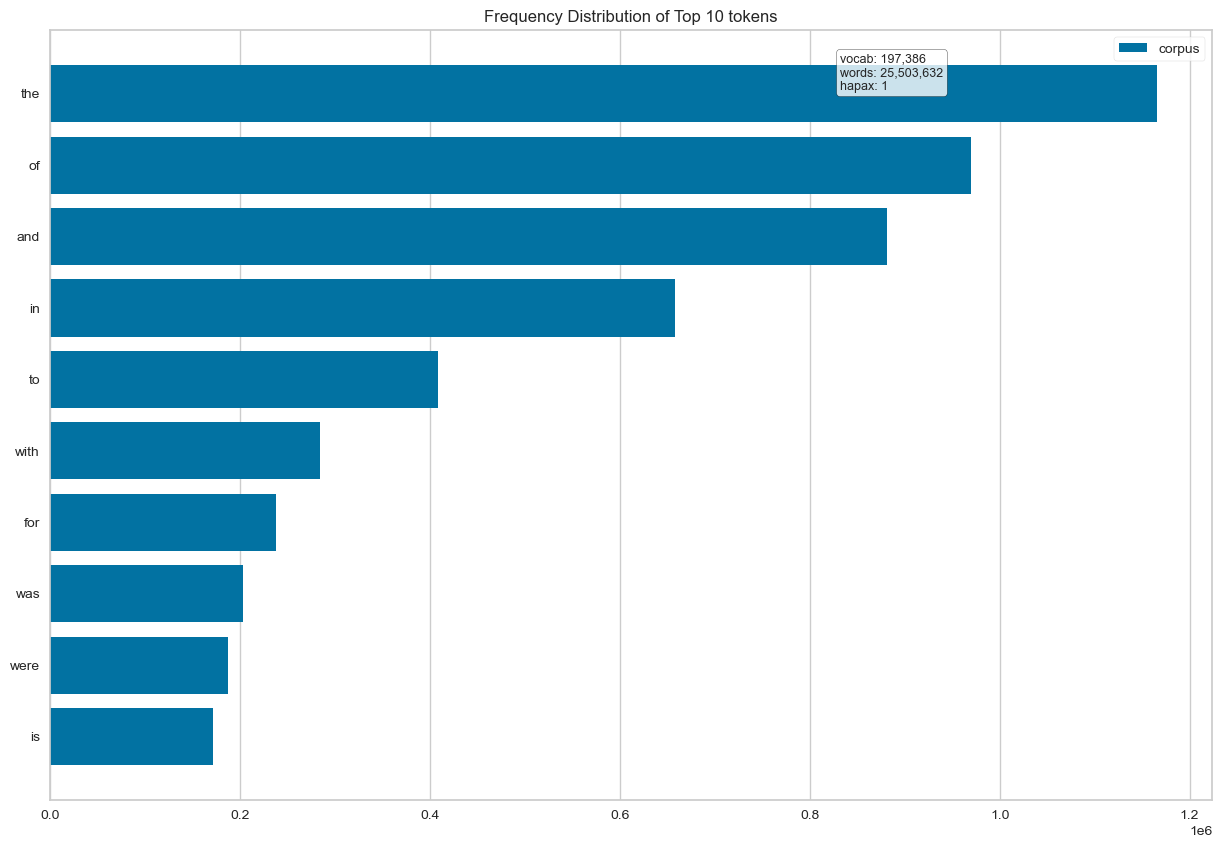

<AxesSubplot:title={'center':'Frequency Distribution of Top 10 tokens'}>

In [15]:
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(nlp_data['text'].tolist())
features   = vectorizer.get_feature_names_out()

fig = plt.figure(figsize=(15,10))
visualizer = FreqDistVisualizer(features = features, orient='h', n=10)
visualizer.fit(docs)
visualizer.show()

### bigrams

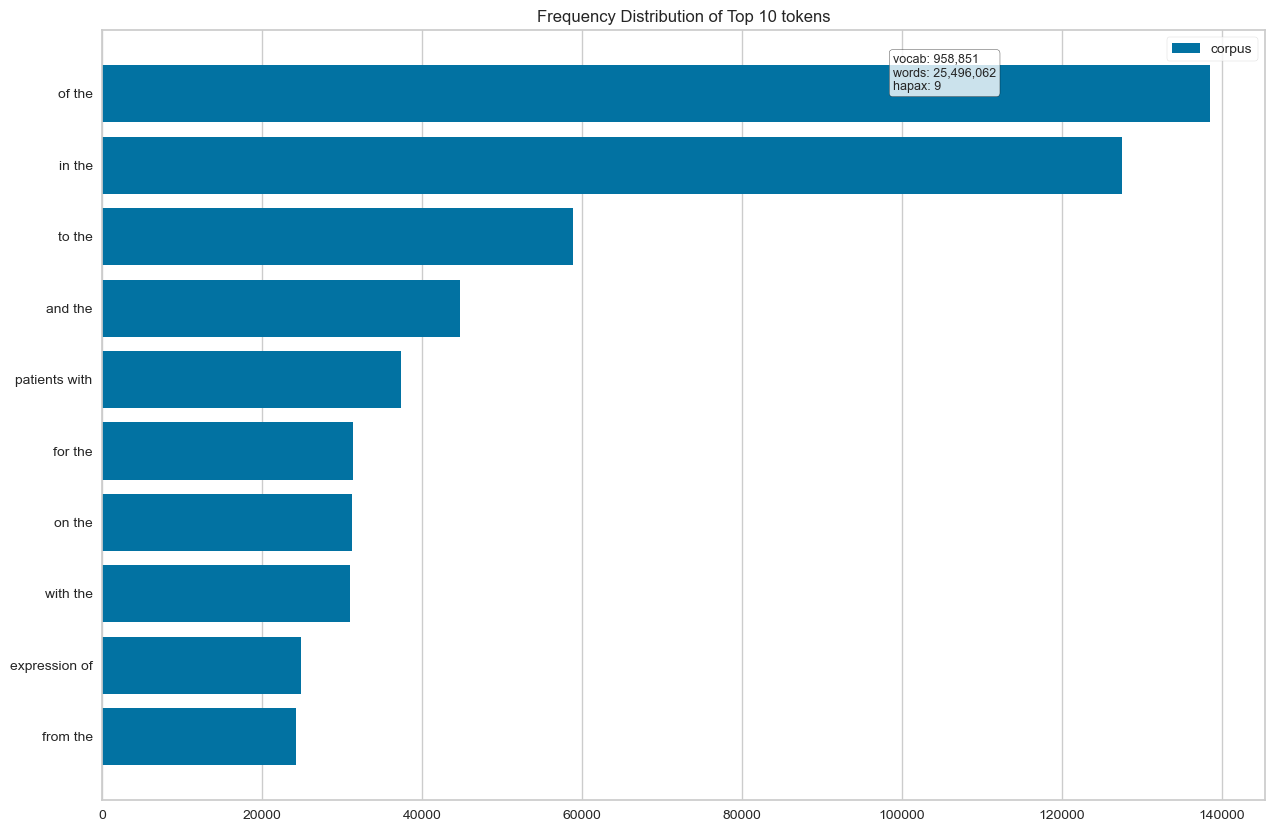

<AxesSubplot:title={'center':'Frequency Distribution of Top 10 tokens'}>

In [16]:
fig = plt.figure(figsize=(15,10))
vectorizer = CountVectorizer(ngram_range=(2, 2))
docs       = vectorizer.fit_transform(nlp_data['text'].tolist())
features   = vectorizer.get_feature_names_out()

visualizer = FreqDistVisualizer(features=features, orient='h', n=10)
visualizer.fit(docs)
visualizer.show()

    frequent words

###  Wordcloud

### Thyroid_Cancer

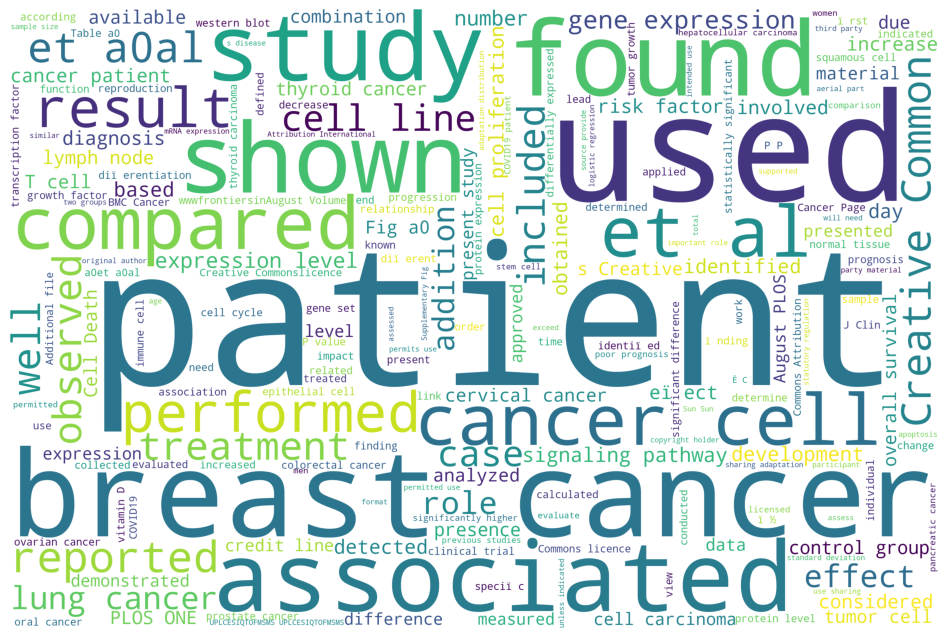

In [17]:
data = nlp_data[nlp_data['cancer']=='Thyroid_Cancer']['text']
plt.figure(figsize=(12,10))

wordcloud = WordCloud(background_color='white',
                      width=3000,
                      stopwords = STOPWORDS,
                      height=2000
                         ).generate(' '.join(data))


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Colon_Cancer

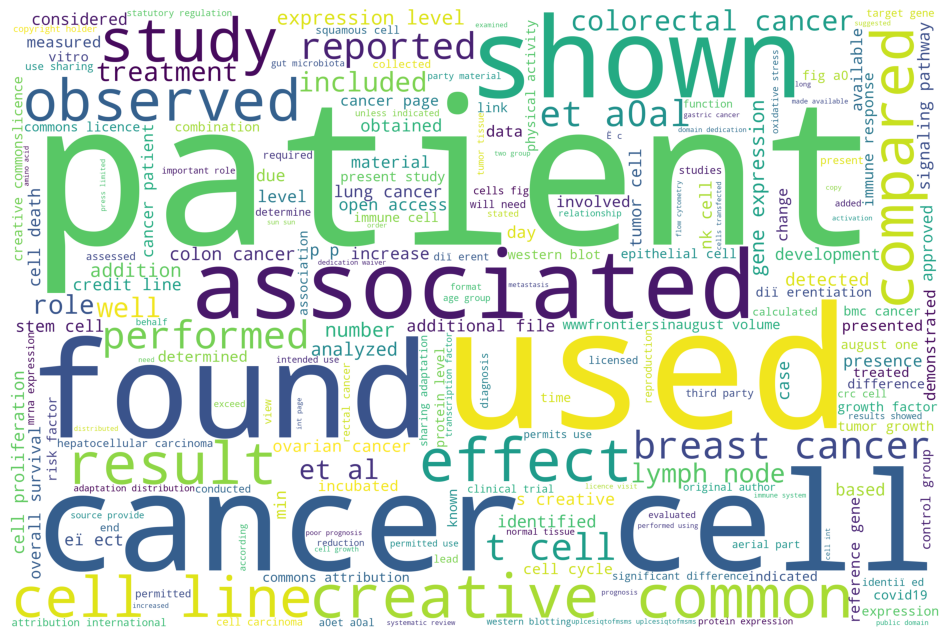

In [18]:
data = nlp_data[nlp_data['cancer']=='Colon_Cancer']['text']
plt.figure(figsize=(12,10))

wordcloud = WordCloud(background_color='white',
                      width=3000,
                      stopwords = STOPWORDS,
                      height=2000
                         ).generate(' '.join(data))


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Lung_Cancer

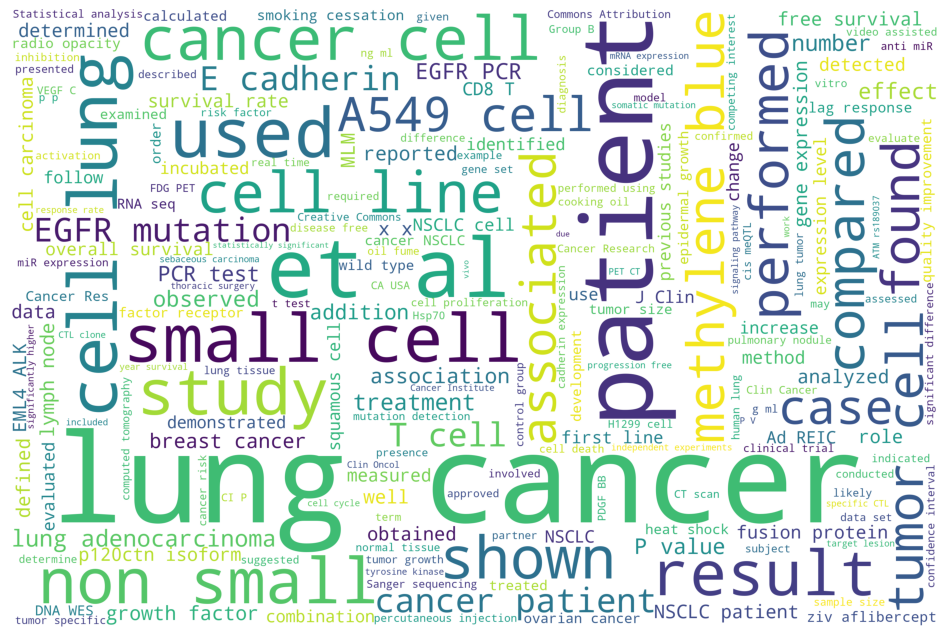

In [19]:
data = nlp_data[nlp_data['cancer']=='Lung_Cancer']['text']
plt.figure(figsize=(12,10))

wordcloud = WordCloud(background_color='white',
                      width=3000,
                      stopwords = STOPWORDS,
                      height=2000
                         ).generate(' '.join(data))


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## STEP 3: Text processing

### transform text to lowercase

In [20]:
nlp_data['text_lw'] = nlp_data['text'].str.lower()
nlp_data[['text', 'text_lw']].head()

text  \
0  Thyroid surgery in  children in a single insti...   
1  " The adopted strategy was the same as that us...   
2  coronary arterybypass grafting thrombosis ï¬b...   
3   Solitary plasmacytoma SP of the skull is an u...   
4   This study aimed to investigate serum matrix ...   

                                             text_lw  
0  thyroid surgery in  children in a single insti...  
1  " the adopted strategy was the same as that us...  
2  coronary arterybypass grafting thrombosis ï¬b...  
3   solitary plasmacytoma sp of the skull is an u...  
4   this study aimed to investigate serum matrix ...

### Stopwords

In [21]:
stop_words = stopwords.words('english')

In [22]:
def clean_text(text):
    text = re.sub('\[.*?\]', '', text)
    # remove links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # remove tags
    text = re.sub('<.*?>+', '', text)
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # remove breaklines
    text = re.sub('\n', '', text)
    # remove numbers
    text = re.sub('\w*\d\w*', '', text)
 
    # tokenization
    text_token = nltk.word_tokenize(text)
    
    words = [word for word in text_token if word not in stop_words]
     
    return ' '.join(words)

nlp_data['text_cl'] = nlp_data['text_lw'].apply(clean_text)
nlp_data[['text','text_lw','text_cl']].head(10)

text  \
0  Thyroid surgery in  children in a single insti...   
1  " The adopted strategy was the same as that us...   
2  coronary arterybypass grafting thrombosis ï¬b...   
3   Solitary plasmacytoma SP of the skull is an u...   
4   This study aimed to investigate serum matrix ...   
5   This study was performed to explore the effec...   
6   This study was performed assess the clinical ...   
7  Journal of International Medical Research  Th...   
8   Gastric cancer GC persists as a worldwide pub...   
9   Scars Burns  HealingVolume     reuse guideli...   

                                             text_lw  \
0  thyroid surgery in  children in a single insti...   
1  " the adopted strategy was the same as that us...   
2  coronary arterybypass grafting thrombosis ï¬b...   
3   solitary plasmacytoma sp of the skull is an u...   
4   this study aimed to investigate serum matrix ...   
5   this study was performed to explore the effec...   
6   this study was performed assess the clinical ...   
7  journal of international medical research  th...   
8   gastric cancer gc persists as a worldwide pub...   
9   scars burns  healingvolume     reuse guideli...   

                                             text_cl  
0  thyroid surgery children single institution os...  
1  adopted strategy used prior years based four e...  
2  coronary arterybypass grafting thrombosis ï¬b...  
3  solitary plasmacytoma sp skull uncommon clinic...  
4  study aimed investigate serum matrix metallopr...  
5  study performed explore effective management b...  
6  study performed assess clinical outcomes elder...  
7  journal international medical research  autho...  
8  gastric cancer gc persists worldwide public he...  
9  scars burns healingvolume  reuse guidelinessa...

### WordNetLemmatizer

In [23]:
lemmatizer = WordNetLemmatizer()

def lemmatize_sentence(text):
    text_token = nltk.word_tokenize(text)
    lemmatized_sentence = []
    for word in text_token:
         lemmatized_sentence.append(word)
    return " ".join(lemmatized_sentence)

In [24]:
nlp_data['text_lm'] = nlp_data['text_cl'].apply(lemmatize_sentence)
nlp_data[['text','text_lw','text_cl', 'text_lm']].head()

text  \
0  Thyroid surgery in  children in a single insti...   
1  " The adopted strategy was the same as that us...   
2  coronary arterybypass grafting thrombosis ï¬b...   
3   Solitary plasmacytoma SP of the skull is an u...   
4   This study aimed to investigate serum matrix ...   

                                             text_lw  \
0  thyroid surgery in  children in a single insti...   
1  " the adopted strategy was the same as that us...   
2  coronary arterybypass grafting thrombosis ï¬b...   
3   solitary plasmacytoma sp of the skull is an u...   
4   this study aimed to investigate serum matrix ...   

                                             text_cl  \
0  thyroid surgery children single institution os...   
1  adopted strategy used prior years based four e...   
2  coronary arterybypass grafting thrombosis ï¬b...   
3  solitary plasmacytoma sp skull uncommon clinic...   
4  study aimed investigate serum matrix metallopr...   

                                             text_lm  
0  thyroid surgery children single institution os...  
1  adopted strategy used prior years based four e...  
2  coronary arterybypass grafting thrombosis ï¬b...  
3  solitary plasmacytoma sp skull uncommon clinic...  
4  study aimed investigate serum matrix metallopr...

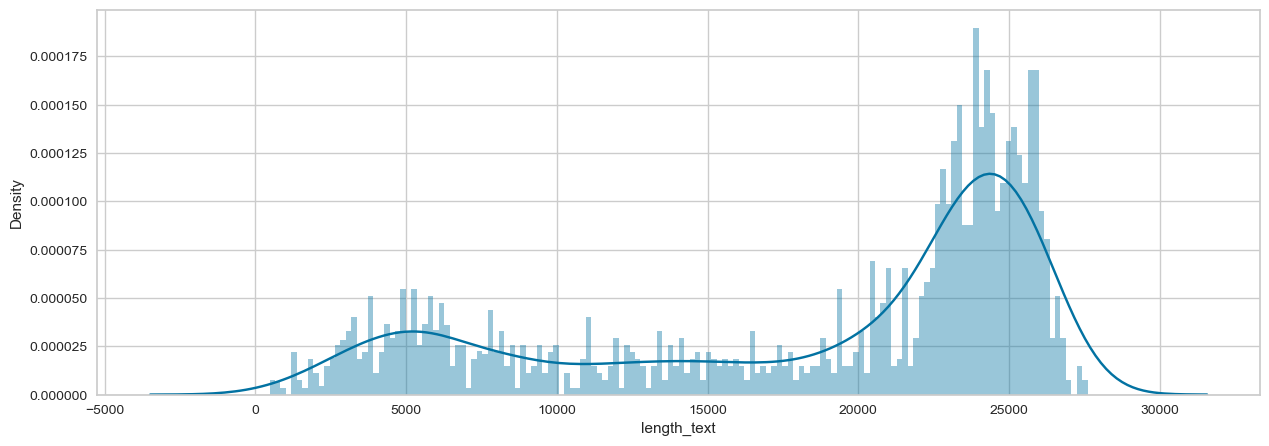

In [25]:
nlp_data['length_text'] = nlp_data['text_lm'].str.len()
plt.figure(figsize=(15,5))
sns.distplot(nlp_data['length_text'],bins = 150)
xlabel= ('length_text') 
ylabel= ('Frequency')
plt.show()

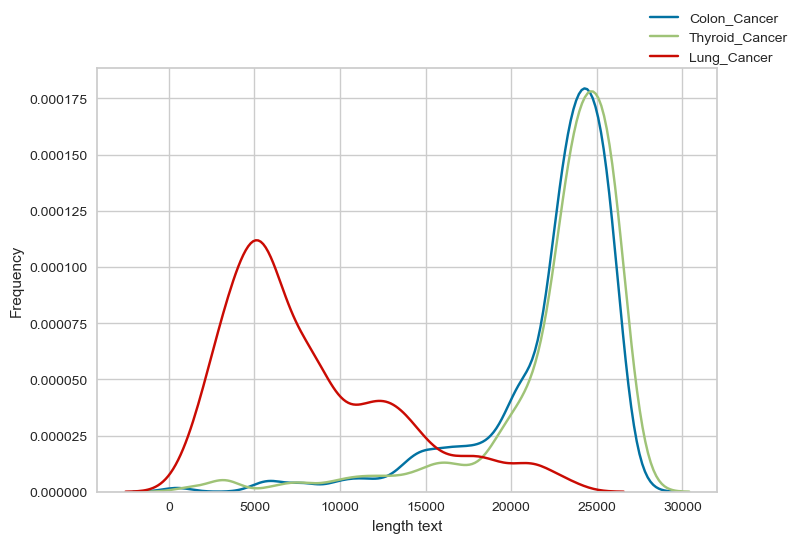

In [26]:
nlp_data['length_text'] = nlp_data['text_lm'].str.len()
fig = plt.figure()
ax = fig.add_subplot(111)

sns.kdeplot(nlp_data[nlp_data['cancer'] == 'Thyroid_Cancer']['length_text'])
sns.kdeplot(nlp_data[nlp_data['cancer'] == 'Colon_Cancer']['length_text'])
sns.kdeplot(nlp_data[nlp_data['cancer'] == 'Lung_Cancer']['length_text'])
ax.set(xlabel='length text', ylabel='Frequency')
fig.legend(labels=['Colon_Cancer','Thyroid_Cancer', 'Lung_Cancer'])
plt.show()

    after the data cleanup, there's a reduction in words to 30,000  Thyroid_Cancer, Colon_Cancer, 
    Lung_Cancer decreases to 5000 words. 

<AxesSubplot:xlabel='cancer', ylabel='length_text'>

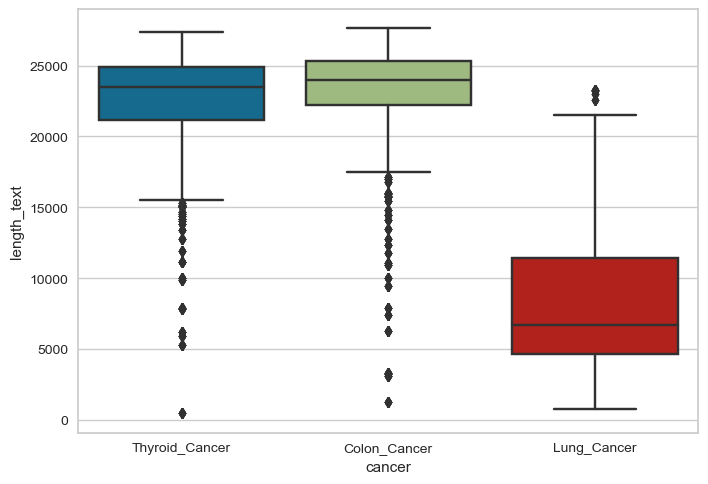

In [27]:
nlp_data['length_text'] = nlp_data['text_lm'].str.len()
fig = plt.figure()
ax = fig.add_subplot()
sns.boxplot(data = nlp_data, x = 'cancer', y = 'length_text')

### Most frequent words

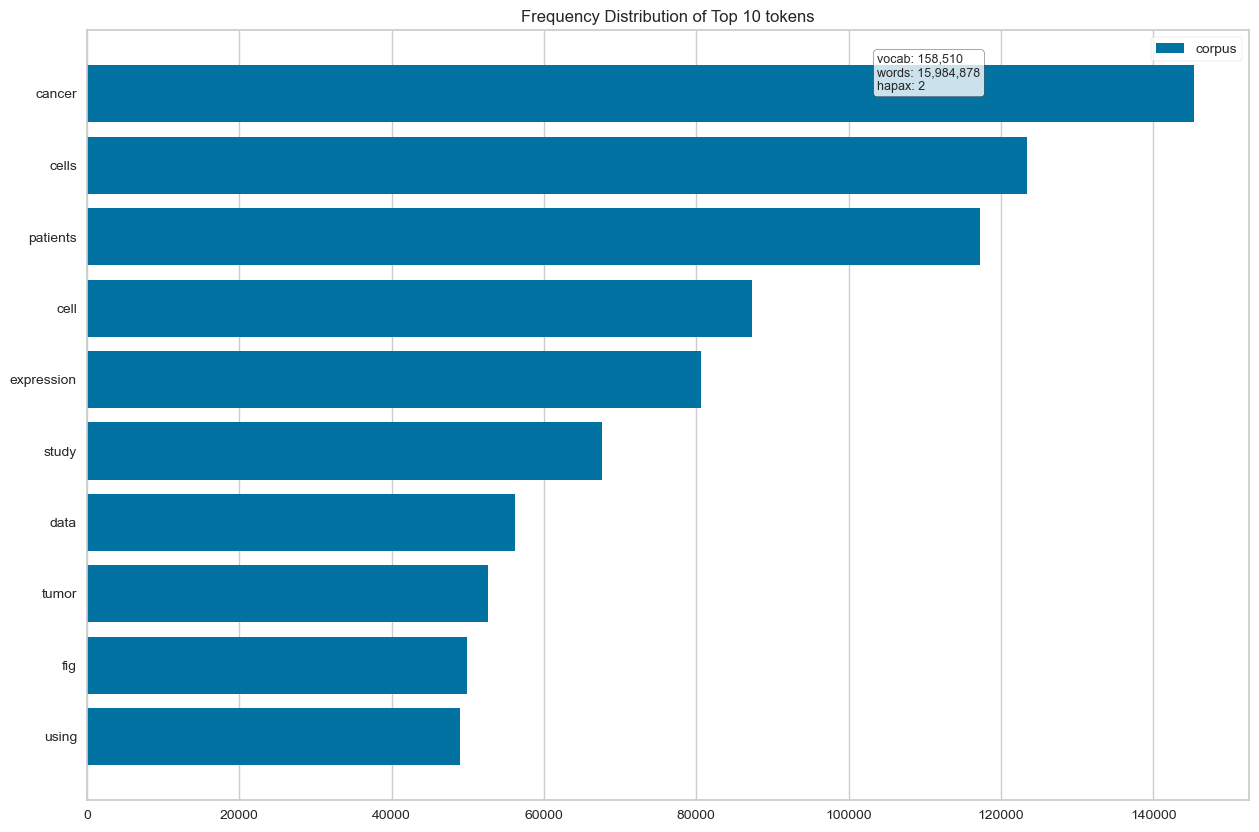

<AxesSubplot:title={'center':'Frequency Distribution of Top 10 tokens'}>

In [28]:
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(nlp_data['text_lm'].tolist())
features   = vectorizer.get_feature_names_out()

fig = plt.figure(figsize=(15,10))
visualizer = FreqDistVisualizer(features = features, orient='h', n=10)
visualizer.fit(docs)
visualizer.show()

### bigrams

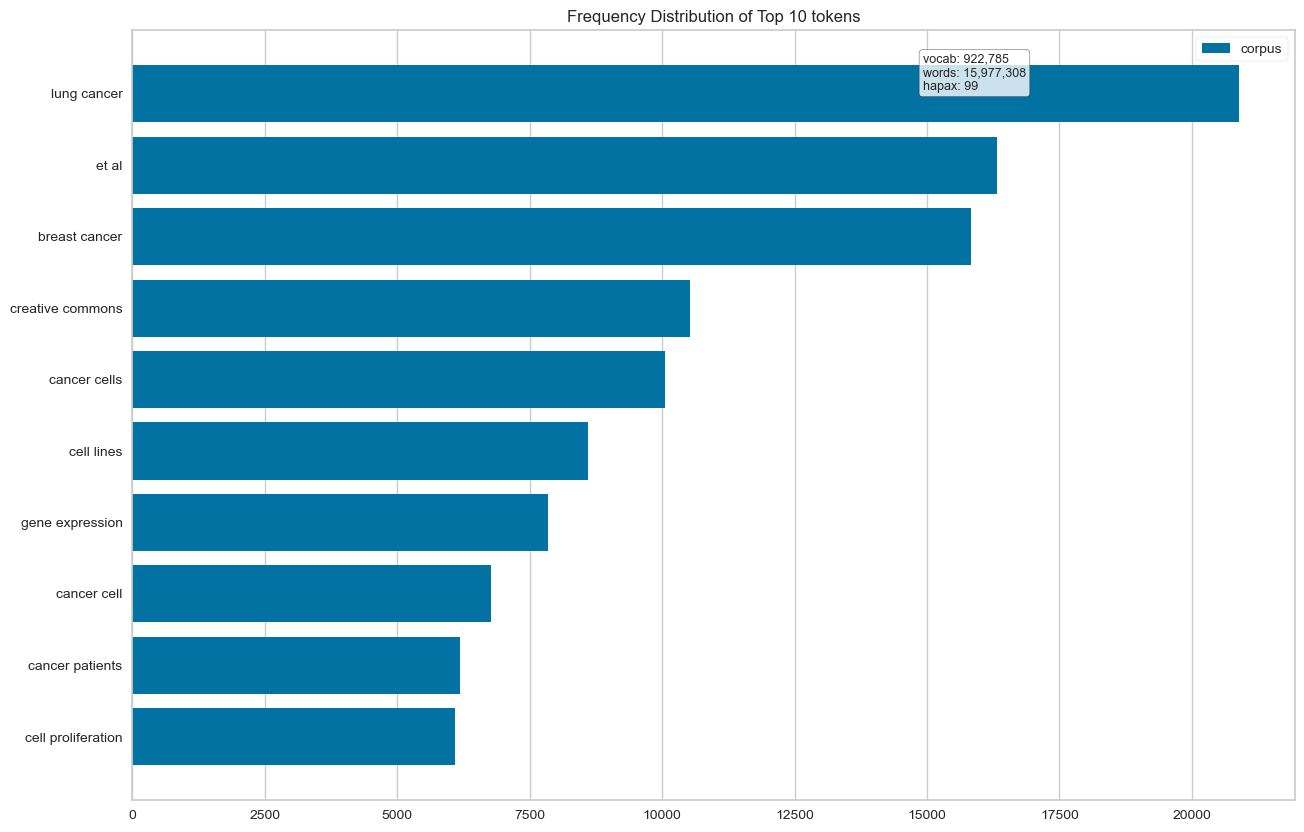

<AxesSubplot:title={'center':'Frequency Distribution of Top 10 tokens'}>

In [29]:
fig = plt.figure(figsize=(15,10))
vectorizer = CountVectorizer(ngram_range=(2, 2))
docs       = vectorizer.fit_transform(nlp_data['text_lm'].tolist())
features   = vectorizer.get_feature_names_out()

visualizer = FreqDistVisualizer(features=features, orient='h', n=10)
visualizer.fit(docs)
visualizer.show()

    frequent words after text processing

### After transformation 
#### Wordcloud

Thyroid_Cancer

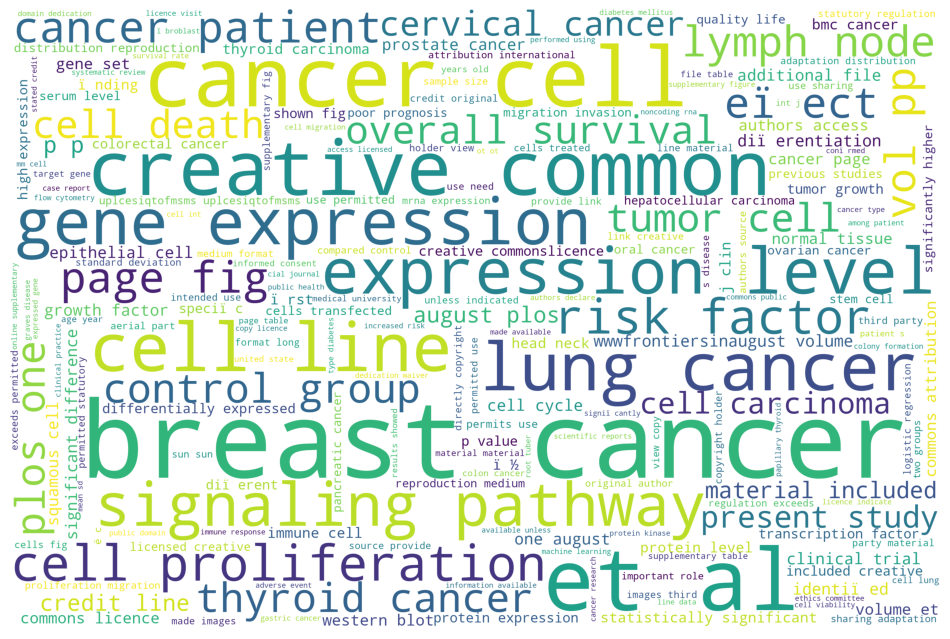

In [30]:
data = nlp_data[nlp_data['cancer']=='Thyroid_Cancer']['text_lm']
plt.figure(figsize=(12,10))

wordcloud = WordCloud(background_color='white',
                      width=3000,
                      stopwords = STOPWORDS,
                      height=2000
                         ).generate(' '.join(data))


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

'Colon_Cancer'

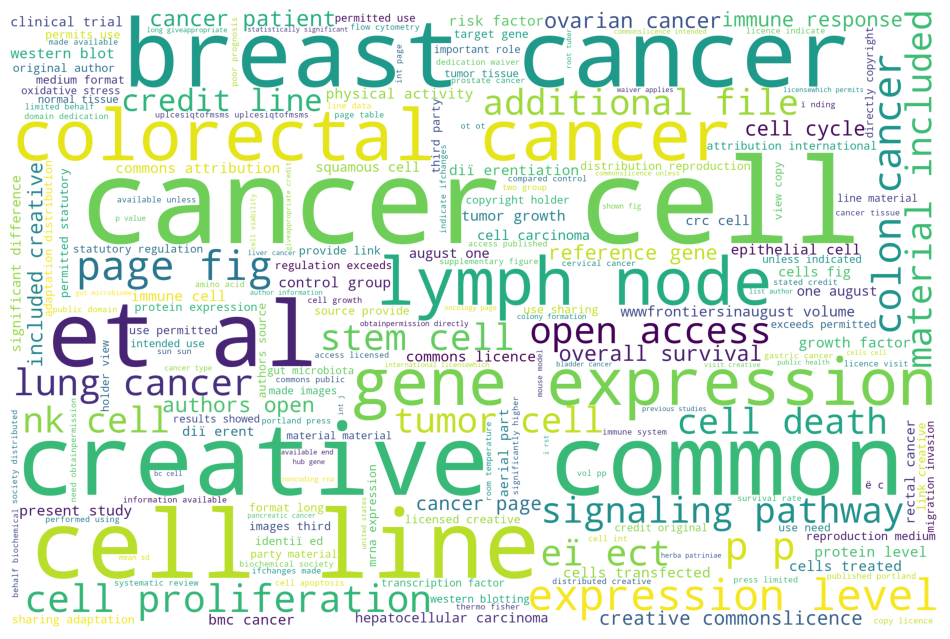

In [31]:
data = nlp_data[nlp_data['cancer']=='Colon_Cancer']['text_lm']
plt.figure(figsize=(12,10))

wordcloud = WordCloud(background_color='white',
                      width=3000,
                      stopwords = STOPWORDS,
                      height=2000
                         ).generate(' '.join(data))


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

'Lung_Cancer'

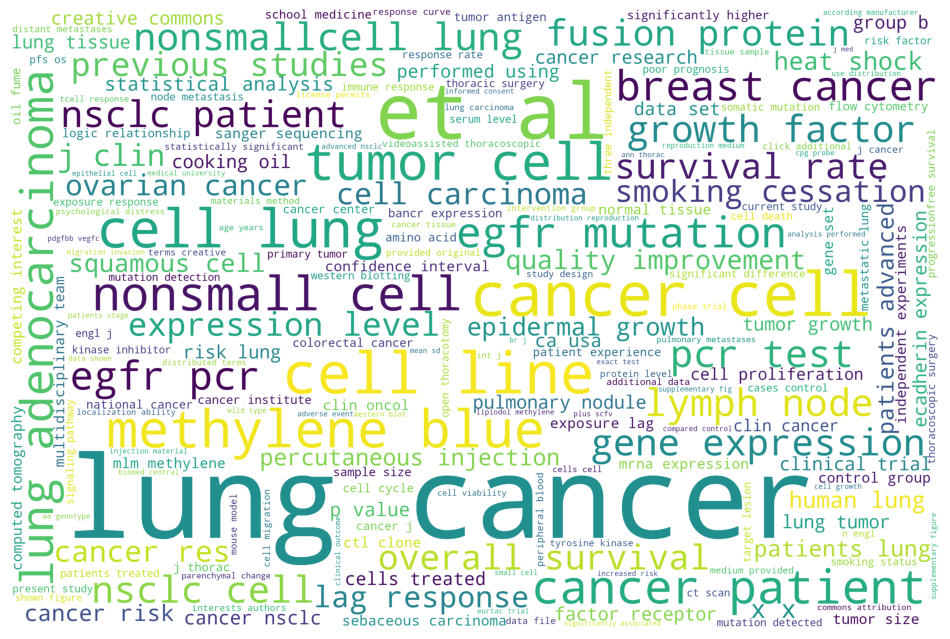

In [32]:
data = nlp_data[nlp_data['cancer']=='Lung_Cancer']['text_lm']
plt.figure(figsize=(12,10))

wordcloud = WordCloud(background_color='white',
                      width=3000,
                      stopwords = STOPWORDS,
                      height=2000
                         ).generate(' '.join(data))


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [33]:
nlp_data

cancer                                               text  \
0     Thyroid_Cancer  Thyroid surgery in  children in a single insti...   
1     Thyroid_Cancer  " The adopted strategy was the same as that us...   
2     Thyroid_Cancer  coronary arterybypass grafting thrombosis ï¬b...   
3     Thyroid_Cancer   Solitary plasmacytoma SP of the skull is an u...   
4     Thyroid_Cancer   This study aimed to investigate serum matrix ...   
...              ...                                                ...   
7565    Colon_Cancer  we report the case of a 24yearold man who pres...   
7566    Colon_Cancer  among synchronous colorectal cancers scrcs rep...   
7567    Colon_Cancer  the heterogeneity of cancer cells is generally...   
7568    Colon_Cancer  "adipogenesis is the process through which mes...   
7569    Colon_Cancer  the periparturient period is one of the most c...   

      length_text                                            text_lw  \
0           16078  thyroid surgery in  children in a single insti...   
1           13375  " the adopted strategy was the same as that us...   
2           17380  coronary arterybypass grafting thrombosis ï¬b...   
3           11129   solitary plasmacytoma sp of the skull is an u...   
4           18774   this study aimed to investigate serum matrix ...   
...           ...                                                ...   
7565         9437  we report the case of a 24yearold man who pres...   
7566         7398  among synchronous colorectal cancers scrcs rep...   
7567        23079  the heterogeneity of cancer cells is generally...   
7568        25000  "adipogenesis is the process through which mes...   
7569        23892  the periparturient period is one of the most c...   

                                                text_cl  \
0     thyroid surgery children single institution os...   
1     adopted strategy used prior years based four e...   
2     coronary arterybypass grafting thrombosis ï¬b...   
3     solitary plasmacytoma sp skull uncommon clinic...   
4     study aimed investigate serum matrix metallopr...   
...                                                 ...   
7565  report case man presented chief complaintsof s...   
7566  among synchronous colorectal cancers scrcs rep...   
7567  heterogeneity cancer cells generally accepted ...   
7568  adipogenesis process mesenchymalstem cells msc...   
7569  periparturient period one challenging periods ...   

                                                text_lm  
0     thyroid surgery children single institution os...  
1     adopted strategy used prior years based four e...  
2     coronary arterybypass grafting thrombosis ï¬b...  
3     solitary plasmacytoma sp skull uncommon clinic...  
4     study aimed investigate serum matrix metallopr...  
...                                                 ...  
7565  report case man presented chief complaintsof s...  
7566  among synchronous colorectal cancers scrcs rep...  
7567  heterogeneity cancer cells generally accepted ...  
7568  adipogenesis process mesenchymalstem cells msc...  
7569  periparturient period one challenging periods ...  

[7570 rows x 6 columns]

In [34]:
nlp_data.drop(labels = ['text','length_text', 'text_lw', 'text_cl' ], axis = 1, inplace = True)
nlp_data

cancer                                            text_lm
0     Thyroid_Cancer  thyroid surgery children single institution os...
1     Thyroid_Cancer  adopted strategy used prior years based four e...
2     Thyroid_Cancer  coronary arterybypass grafting thrombosis ï¬b...
3     Thyroid_Cancer  solitary plasmacytoma sp skull uncommon clinic...
4     Thyroid_Cancer  study aimed investigate serum matrix metallopr...
...              ...                                                ...
7565    Colon_Cancer  report case man presented chief complaintsof s...
7566    Colon_Cancer  among synchronous colorectal cancers scrcs rep...
7567    Colon_Cancer  heterogeneity cancer cells generally accepted ...
7568    Colon_Cancer  adipogenesis process mesenchymalstem cells msc...
7569    Colon_Cancer  periparturient period one challenging periods ...

[7570 rows x 2 columns]

### STEP 4:TfidfVectorizer

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    nlp_data[['text_lm']],
    nlp_data['cancer'],
    test_size= 0.2, 
    random_state = 0)
X_train.shape, y_train.shape,  X_test.shape, y_test.shape

((6056, 1), (6056,), (1514, 1), (1514,))

In [36]:
vectorizer = TfidfVectorizer(max_features = 4600)
X_train_tfid = vectorizer.fit_transform(X_train['text_lm']).toarray()
X_test_tfid = vectorizer.transform(X_test['text_lm']).toarray()

In [37]:
X_train_tfid

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.02090284,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### STEP 5 : Model results

### LogisticRegression

In [38]:
log_reg = LogisticRegression()
log_reg.fit(X_train_tfid, y_train)

LogisticRegression()

In [39]:
y_pred_train_lr = log_reg.predict(X_train_tfid)

y_pred_test_lr = log_reg.predict(X_test_tfid)

print('Train set')
print('LogisticRegression accuracy: {}'.format(accuracy_score(y_train, y_pred_train_lr)))
print('Test set')
print('LogisticRegression accuracy: {}'.format(accuracy_score(y_test, y_pred_test_lr)))
print(classification_report(y_test, y_pred_test_lr))

Train set
LogisticRegression accuracy: 0.9640026420079261
Test set
LogisticRegression accuracy: 0.9458388375165125
                precision    recall  f1-score   support

  Colon_Cancer       0.92      0.92      0.92       508
   Lung_Cancer       1.00      1.00      1.00       433
Thyroid_Cancer       0.93      0.93      0.93       573

      accuracy                           0.95      1514
     macro avg       0.95      0.95      0.95      1514
  weighted avg       0.95      0.95      0.95      1514



<AxesSubplot:>

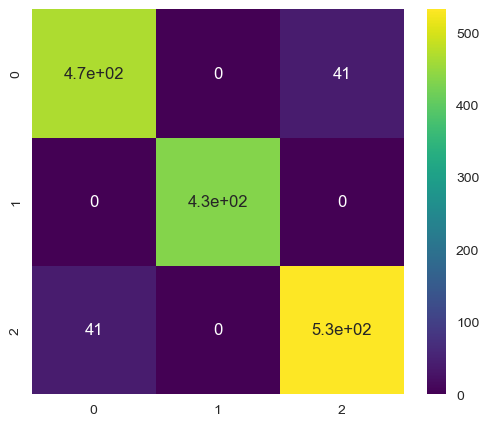

In [40]:
cm = confusion_matrix(y_test, y_pred_test_lr)
plt.figure(figsize = (6, 5))
sns.heatmap(cm, cmap= 'viridis', annot = True)

### MultinomialNB

In [41]:
mnb_classifier= MultinomialNB()
mnb_classifier.fit(X_train_tfid, y_train)

MultinomialNB()

In [42]:
y_pred_train_mnb = mnb_classifier.predict(X_train_tfid)

y_pred_test_mnb = mnb_classifier.predict(X_test_tfid)

print('Train set')
print('MultinomialNB accuracy: {}'.format(accuracy_score(y_train, y_pred_train_mnb)))
print('Test set')
print('MultinomialNB accuracy: {}'.format(accuracy_score(y_test, y_pred_test_mnb)))
print(classification_report(y_test, y_pred_test_mnb))

Train set
MultinomialNB accuracy: 0.88721928665786
Test set
MultinomialNB accuracy: 0.8566710700132101
                precision    recall  f1-score   support

  Colon_Cancer       0.81      0.77      0.79       508
   Lung_Cancer       0.98      0.99      0.99       433
Thyroid_Cancer       0.80      0.83      0.82       573

      accuracy                           0.86      1514
     macro avg       0.87      0.86      0.86      1514
  weighted avg       0.86      0.86      0.86      1514



<AxesSubplot:>

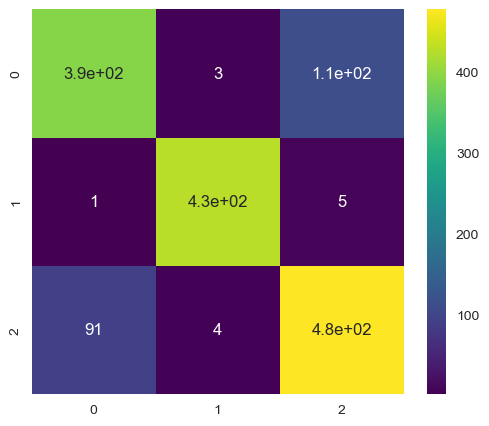

In [43]:
cm = confusion_matrix(y_test, y_pred_test_mnb)
plt.figure(figsize = (6, 5))
sns.heatmap(cm, cmap= 'viridis', annot = True)

### GaussianNB

In [44]:
gnb = GaussianNB()
gnb.fit(X_train_tfid, y_train)

GaussianNB()

In [45]:
y_pred_train_gnb = gnb.predict(X_train_tfid)

y_pred_test_gnb = gnb.predict(X_test_tfid)

print('Train set')
print('GaussianNB accuracy: {}'.format(accuracy_score(y_train, y_pred_train_gnb)))
print('Test set')
print('GaussianNB accuracy: {}'.format(accuracy_score(y_test, y_pred_test_gnb)))
print(classification_report(y_test, y_pred_test_gnb))

Train set
GaussianNB accuracy: 0.9375825627476883
Test set
GaussianNB accuracy: 0.9128137384412153
                precision    recall  f1-score   support

  Colon_Cancer       0.86      0.88      0.87       508
   Lung_Cancer       1.00      1.00      1.00       433
Thyroid_Cancer       0.89      0.88      0.88       573

      accuracy                           0.91      1514
     macro avg       0.92      0.92      0.92      1514
  weighted avg       0.91      0.91      0.91      1514



<AxesSubplot:>

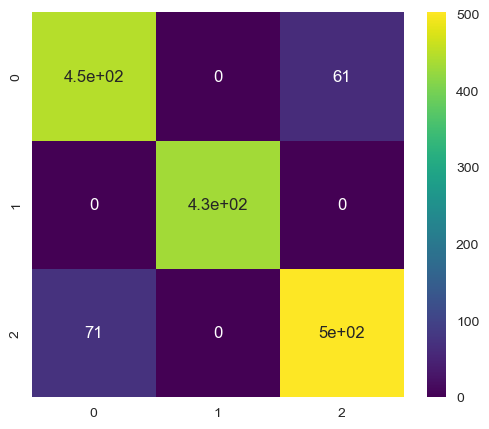

In [46]:
cm = confusion_matrix(y_test, y_pred_test_gnb)
plt.figure(figsize = (6, 5))
sns.heatmap(cm, cmap= 'viridis', annot = True)

### BernoulliNB

In [47]:
bnb = BernoulliNB()
bnb.fit(X_train_tfid, y_train)

BernoulliNB()

In [48]:
y_pred_train_bnb = bnb.predict(X_train_tfid)

y_pred_test_bnb = bnb.predict(X_test_tfid)

print('Train set')
print('BernoulliNB accuracy: {}'.format(accuracy_score(y_train, y_pred_train_bnb)))
print('Test set')
print('BernoulliNB accuracy: {}'.format(accuracy_score(y_test, y_pred_test_bnb)))
print(classification_report(y_test, y_pred_test_bnb))

Train set
BernoulliNB accuracy: 0.7732826948480845
Test set
BernoulliNB accuracy: 0.73778071334214
                precision    recall  f1-score   support

  Colon_Cancer       0.64      0.67      0.65       508
   Lung_Cancer       0.94      0.93      0.93       433
Thyroid_Cancer       0.68      0.65      0.67       573

      accuracy                           0.74      1514
     macro avg       0.75      0.75      0.75      1514
  weighted avg       0.74      0.74      0.74      1514



<AxesSubplot:>

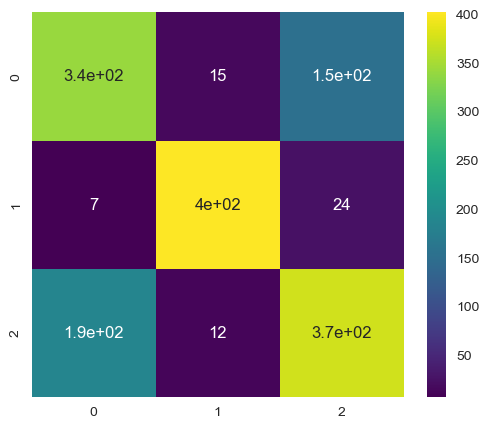

In [49]:
cm = confusion_matrix(y_test, y_pred_test_bnb)
plt.figure(figsize = (6, 5))
sns.heatmap(cm, cmap= 'viridis', annot = True)

In [50]:
explainer = LimeTextExplainer(class_names=['Thyroid_Cancer','Colon_Cancer', 'Lung_Cancer'])

In [51]:
c = make_pipeline(vectorizer, log_reg)

X_test['cancer'] = y_test.values
X_test['pred'] = y_pred_test_lr
X_test

text_lm          cancer  \
2902  current research developed silver iron nanops ...    Colon_Cancer   
229   optimizing telemedicine encounters oral maxill...  Thyroid_Cancer   
5803  purpose explore new therapeutic option patient...    Colon_Cancer   
979   study aimed investigate serum matrix metallopr...  Thyroid_Cancer   
4824  advances technology hardware computing created...    Colon_Cancer   
...                                                 ...             ...   
2265  median time distant metastases ± months hcrt g...     Lung_Cancer   
3447  objectives describe benefits limitations using...    Colon_Cancer   
3724  dyebias equalization used global scaling facto...     Lung_Cancer   
2063  ne bpde involved inducing dna adducts thus mad...     Lung_Cancer   
1421  immunotherapy revolutionising cancer treatment...    Colon_Cancer   

                pred  
2902    Colon_Cancer  
229   Thyroid_Cancer  
5803    Colon_Cancer  
979   Thyroid_Cancer  
4824    Colon_Cancer  
...              ...  
2265     Lung_Cancer  
3447  Thyroid_Cancer  
3724     Lung_Cancer  
2063     Lung_Cancer  
1421    Colon_Cancer  

[1514 rows x 3 columns]

In [52]:
c = make_pipeline(vectorizer, mnb_classifier)

X_test['cancer'] = y_test.values
X_test['pred'] = y_pred_test_mnb
X_test

text_lm          cancer  \
2902  current research developed silver iron nanops ...    Colon_Cancer   
229   optimizing telemedicine encounters oral maxill...  Thyroid_Cancer   
5803  purpose explore new therapeutic option patient...    Colon_Cancer   
979   study aimed investigate serum matrix metallopr...  Thyroid_Cancer   
4824  advances technology hardware computing created...    Colon_Cancer   
...                                                 ...             ...   
2265  median time distant metastases ± months hcrt g...     Lung_Cancer   
3447  objectives describe benefits limitations using...    Colon_Cancer   
3724  dyebias equalization used global scaling facto...     Lung_Cancer   
2063  ne bpde involved inducing dna adducts thus mad...     Lung_Cancer   
1421  immunotherapy revolutionising cancer treatment...    Colon_Cancer   

                pred  
2902    Colon_Cancer  
229   Thyroid_Cancer  
5803  Thyroid_Cancer  
979   Thyroid_Cancer  
4824  Thyroid_Cancer  
...              ...  
2265     Lung_Cancer  
3447  Thyroid_Cancer  
3724     Lung_Cancer  
2063     Lung_Cancer  
1421    Colon_Cancer  

[1514 rows x 3 columns]

### Conclusion: 

    A text document with a maximum word count of over 30000 words contains 3 categories: thyroid cancer, lung cancer and colon cancer. 
    After processing the data, the text was reduced to 30000 words. 

    Models I'm training: LogisticRegression, MultinomialNB, GaussianNB, BernoulliNB 

    LogisticRegression predicts better, train 96%, test 94%. 